In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
import os
import pathlib
PATH = pathlib.Path().resolve()
PATH

WindowsPath('C:/Users/camsp/Documents/Universidad/DiplomadoML-BD/MLops/tdsp_template/scripts/training')

In [2]:
data = pd.read_csv("../../data/ds_train.csv")
data

,path,mask,segmented
65,../../data/train\case101\case101_day20\scans\s...,../../data/masks\case101\case101_day20\scans\s...,1
66,../../data/train\case101\case101_day20\scans\s...,../../data/masks\case101\case101_day20\scans\s...,1
67,../../data/train\case101\case101_day20\scans\s...,../../data/masks\case101\case101_day20\scans\s...,1
68,../../data/train\case101\case101_day20\scans\s...,../../data/masks\case101\case101_day20\scans\s...,1
69,../../data/train\case101\case101_day20\scans\s...,../../data/masks\case101\case101_day20\scans\s...,1
...,...,...,...
38466,../../data/train\case9\case9_day22\scans\slice...,../../data/masks\case9\case9_day22\scans\slice...,1
38467,../../data/train\case9\case9_day22\scans\slice...,../../data/masks\case9\case9_day22\scans\slice...,1
38468,../../data/train\case9\case9_day22\scans\slice...,../../data/masks\case9\case9_day22\scans\slice...,1
38469,../../data/train\case9\case9_day22\scans\slice...,../../data/masks\case9\case9_day22\scans\slice...,1


In [3]:
BATCH_SIZE = 1

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data['path'], data['mask'], stratify=data["segmented"],  test_size=0.2, random_state=24)
train_images_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_images_ds   = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [6]:
def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

def read_images(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3, dtype=tf.float32, expand_animations=False)
    image = tf.image.resize(image, [256,256])
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_image(mask, channels=3, dtype=tf.float32, expand_animations=False)
    mask = tf.image.resize(mask, [256,256])
    mask = tf.convert_to_tensor(mask, dtype=tf.float32)
    image, mask = normalize(image, mask)
    
    return image, mask

In [7]:
train_images_ds = train_images_ds.map(read_images, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)
val_images_ds = val_images_ds.map(read_images, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

In [8]:
from tensorflow.keras import * 
from tensorflow.keras.layers import * 

def downsample(filters, apply_batchnorm = True):
    model = Sequential()
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    model.add(Conv2D(filters, 
                     kernel_size = 4,
                     strides = 2,
                     padding = "same",
                     kernel_initializer = initializer,
                     use_bias = not apply_batchnorm))
    
    if apply_batchnorm:
        model.add(BatchNormalization())
        
    model.add(LeakyReLU())
    
    return model

In [9]:
def upsample(filters, apply_dropout = False):
    model = Sequential()
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    model.add(Conv2DTranspose(filters,
                              kernel_initializer = initializer,
                              strides = 2,
                              kernel_size = 4,
                              padding = "same",
                              use_bias = False))
    
    model.add(BatchNormalization())
    
    if apply_dropout:
        model.add(Dropout(0.5))
        
    model.add(ReLU())
    
    return model

In [10]:
def Generate_model():
    inputs  = tf.keras.layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, apply_batchnorm=False),
        downsample(128),
        downsample(256),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512),
        downsample(512)
    ]
    
    up_stack = [
        upsample(512, apply_dropout=True),
        upsample(512, apply_dropout=True),
        upsample(512, apply_dropout=True),
        upsample(512),
        upsample(256),
        upsample(128),
        upsample(64)
    ]
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    last = Conv2DTranspose(filters = 3,
                          kernel_size = 4,
                          strides = 2,
                          padding = "same",
                          kernel_initializer = initializer,
                          activation = "tanh")
    x = inputs
    s = []
    
    concat = Concatenate()

    for down in down_stack:
        x = down(x)
        s.append(x)

    s = reversed(s[:-1])

    for up, sk in zip(up_stack, s):
        x = up(x)
        x = Concatenate()([x, sk])

    last = last(x)
    
    return Model(inputs = inputs, outputs = last)

generator = Generate_model()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3136        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

In [11]:
def Discriminator():
    ini = Input(shape = [None, None, 3], name="input_image")
    gen = Input(shape = [None, None, 3], name="gen_image")
    
    con = concatenate([ini, gen])
    
    initializer = tf.random_normal_initializer(0, 0.02)
    
    down1 = downsample(64, apply_batchnorm=False)(con)
    down2 = downsample(128)(down1)
    down3 = downsample(256)(down2)
    down4 = downsample(512)(down3)
    
    last = Conv2D(filters = 3,
                 kernel_size = 4,
                 strides = 1,
                 kernel_initializer = initializer,
                 padding = "same")(down4)
    return Model(inputs=[ini, gen], outputs=last)
discriminator = Discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 gen_image (InputLayer)         [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 concatenate_8 (Concatenate)    (None, None, None,   0           ['input_image[0][0]',            
                                6)                                'gen_image[0][0]']        

In [12]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [13]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    
    total_disc_loses = real_loss + generated_loss
    
    return total_disc_loses

LAMBDA = 100
def generator_loss(disc_real_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    total_gen_loss = gan_loss + LAMBDA * l1_loss
    
    return total_gen_loss, gan_loss, l1_loss

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

checkpoint_prefix = os.path.join(PATH)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)
#checkpoint.restore(tf.train.latest_checkpoint(PATH)).assert_consumed()

In [15]:
def generate_images(model, test_input, tar, save_filename=False, display_imgs=True):
    prediction = model(test_input, training=True)
    if save_filename:
        tf.keras.preprocessing.image.save_img("../../data/results/"+save_filename+".jpg", ((prediction[0,...].numpy()+1)*127.5))
    
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Mask', 'Predicted Image']
    display_list = [(test_input[0,...].numpy()+1)*127.5, (tar[0,...].numpy()+1)*127.5, (prediction[0,...].numpy()+1)*127.5]
    title = ['Input Image', 'Mask', 'Predicted Image']
    if display_imgs:
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i])
            plt.axis("off")
    if save_filename:
        plt.savefig("../../data/results/"+save_filename+"plots.jpg")
    plt.show()
    

In [16]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
        tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
        tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [17]:
import datetime
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [69]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

In [18]:
import time
from IPython.display import clear_output
def fit(dataset, test, epochs):
    example_input, example_target = next(iter(val_images_ds.skip(50).take(1)))
    start = time.time()
    start = time.time()
    for epoch in range(epochs):
        imgi = 0
        start = time.time()
        for input_image, target in dataset:
            print("epoch " + str(epoch) + " - train: " + str(imgi) + "/" + str(len(train_images_ds)))
            imgi+=1
            train_step(input_image, target, epochs)
            clear_output(wait=True)

        generate_images(generator, example_input, example_target, str(imgi) + "_"+ str(epoch), display_imgs=True)
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
        if (epoch + 1)%10 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


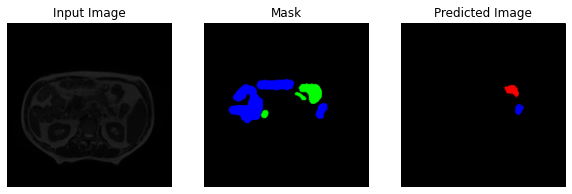

Time taken for 1000 steps: 600.31 sec



In [19]:
fit(train_images_ds, val_images_ds, 100)